In [71]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px

mpl.rc('font', family='Malgun Gothic')

In [72]:
booking = pd.read_csv('booking_data.csv')
cooking = pd.read_csv('Cooking_data_set.csv')
error = pd.read_csv('Error_Message.csv')
product = pd.read_csv('Product_Name.csv')

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_8108\1590912513.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  booking = pd.read_csv('booking_data.csv')


# Cooking 전처리
- 품목코드로 품목명 가져오고, Nan인 것은 분석 대상에서 제외
- 날짜 타입으로 변환
- 작업장 별 온도 확인
- 품목코드 널값 채우기

In [67]:
# # - 품목코드로 품목명 가져오고, Nan인 것은 분석 대상에서 제외
# cooking = pd.merge(cooking, product[['품목코드', '품목명']], on = '품목코드', how = 'inner').dropna().rename(columns={'품목명_x' : '품목명'}).drop(columns='품목명_y')
# # - 날짜 타입으로 변환
# # cooking['생산일자'] = pd.to_datetime(cooking.생산일자)

# # - 작업장 별 온도 확인
# W005 = cooking.loc[cooking.작업장코드 == 'W005']   #  230  +  24 = 254개 이상치
# W003 = cooking.loc[cooking.작업장코드 == 'W003']   #  31 +  16  =>  47개 이상치
# W007 = cooking.loc[cooking.작업장코드 == 'W007']   # 31  +  0   =>  31개 이상치
# W002 = cooking.loc[cooking.작업장코드 == 'W002']   # 4   +  0    =>  4개
# W012 = cooking.loc[cooking.작업장코드 == 'W012']   #  0 +  0  =>  0개      =>  총 336개

# # W005 이상치가 많아서 제조하는 품목을 확인해봄  =>  볶음 요리와 소스를 같이 만듦,, 근데 이건 충전실온도잖아,,? 상관 없지 않을까,,

# 온도 / 압력에 대해 정규성 확인   =>  오류  /  비의도적오료 + 정상에 대해 태그 붙이기
  =>  이상 예측 모델 생성
  - cooking 전처리 안하고 돌리기

In [68]:
import scipy.stats as stats

# 충전실온도	실링온도	쿠킹온도	쿠킹스팀압력	실링압력	
r, p = stats.normaltest(cooking.실링압력)
p

# 1.708652628163289e-132
# 2.8874419255161754e-239
# 2.8115044700191167e-238
# 4.522982556357552e-16
# 0.3461484449894646

0.3461484449894646

In [69]:
cooking.describe()

,순번,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간
count,22913.000000,22913.000000,22913.000000,22913.000000,22913.000000,22913.000000,22913.000000
mean,8.573212,71.685596,101.378033,136.969151,23.727424,208.354949,75.684916
std,7.376756,0.857330,12.486465,12.480518,0.232040,3.622939,2.695066
min,1.000000,68.217193,65.050311,100.058961,22.919000,194.239000,69.690000
25%,3.000000,71.181821,91.825021,127.329544,23.581000,205.912000,73.420000
50%,6.000000,71.728884,99.786921,135.491921,23.728000,208.361000,75.670000
75%,12.000000,72.250837,109.162083,144.771468,23.864000,210.788000,77.950000
max,62.000000,74.086660,140.799501,176.823600,24.580000,223.702000,82.580000


# Error Data 전처리   :   에러데이터와 생산 데이터 inner join
1. 생산일자 날짜 타입으로 변환
2. 오류조치시간 재계산
  0 분은 0분으로 계산하는 것이 합당해 보인다는 의견
3. 고의/비고의 칼럼 만들기  :  '기계결함오류'
  - 비고의  =>  True  
  - 고의  =>  False

In [73]:
# cooking과 error 병합 후 품목명 없는 행은 삭제
cook_error = pd.merge(cooking,error, on=['생산라인코드', '생산라인명', '생산일자', '순번', '품목코드', '품목명'],how = 'inner')
cook_error = cook_error.drop_duplicates(['생산라인코드', '생산일자', '순번', '생산라인명', '품목코드', '품목명'], keep='first')
cook_error = cook_error.loc[~cook_error.품목코드.isna()]
cook_error = cook_error.loc[~cook_error.품목명.isna()]


# 1. 생산일자 날짜 타입으로 변환
cook_error.생산일자 = pd.to_datetime(cook_error.생산일자)


# 2. 오류조치시간 재계산

def re_cal(x):
  while x <= 0:
    x += 1440
  return x
cook_error['re_오류조치시간'] = cook_error['오류조치시간'].apply(re_cal)
cook_error.Error_Message = error.Error_Message.replace('품목교체', '품목 교체')


# 3. 고의/비고의 칼럼 만들기  :  '기계결함오류'
  # - 비고의  =>  True  
  # - 고의  =>  False
human = ['위치조정', '대기', '충전', '식사', '교육', '교체', '불량교체', '시생산 지연', '휴식','조회','연구확인대기',
         '청소', '라벨교체',  '시생산', '정지', '결근', '기기세팅', '품목 교체', '세부 세척', '공정',
         '별도구작업', '품목교체', '수리', '볶음', '업체미입고(생산미지연,순서변경)', '관리팀미입고(생산지연)', '업체미입고(생산지연)', '은박교체'
         , '관리팀미입고(생산미지연,순서변경)', '냉동품 투입', 'PSD패킹 교체', '대차 적재 공간 부족', '용기미입고', '박스 준비', 
         'QA 규격 확인 대기', '라벨 미입고', '부족',  'QA확인대기', '약품 부족', '연구 규격 확인 대기', '모터이상', '계량실', '체인', 
       '이송끊김'
         ]
machine = ['구동부', '충진 미종료', '노즐', '인쇄불량', '시밍',
       '전처리', '히터', '그립퍼', '씰바 셋팅',
       '냉각', '제품 넘어짐 청소', '원료', '야채실', '컨베이어', '규격보정', '감도', '실바',
       '센서', '미포장', '쿠커배합 미종료', '온도 상승 지연', 
        '펌프이상', '제품 넘침 청소',  '오리히로'
       , '밸브', '설비', '분사노즐', 'Air (컴푸레샤)',
       '진공', '이물 혼입', '6열컵실러', '보일러 꺼짐', '필름(파우더불량)', '색상 이상', 'Brix 이상',  '고장', '냉각(칠러)', '점도이상', '전기',
         '라벨부착 오류', '실린더', '아이마크', '일부인 짤림',
        '압력 부족', '용기불량', '용수탱크 저수위', 'ph 이상',
       '푸딩 충전기', '염도이상', '원료 미입고', '스팀 압력', '본체 고장', '충진라인 중복',
       '메카니칼 씰', '구동부 이상', '냉각 미종료', '헤드', '병 끼임', '로타리1', '컷팅기', '감도 조절',
       '사이드 글라스', '점도', '원료 지연', '과부하(제품끼임)' ]



def tag(x):
  if x in human:
    return 'False'
  return 'True'

cook_error['기계결함오류'] = cook_error.Error_Message.apply(tag)
cook_error

,순번,생산라인코드,생산라인명,생산일자,품목코드,품목명,작업장코드,충전실온도,실링온도,쿠킹온도,...,실링압력,생산시간,발생시간,종료시간,오류조치시간,비가동코드,Error_Message,오류발생작업장명,re_오류조치시간,기계결함오류
0,10,D004,PET병,2011-01-03,13D02080,참깨흑임자드레싱,W005,71.125831,93.425831,127.878281,...,201.430,NaN,14:16,14:24,8,W0056B4,위치조정,충전실,8,False
1,7,D011,2동 오리히로,2011-01-04,16A01016,시아스고구마샐러드믹스,W005,71.587470,103.987470,138.736120,...,204.974,NaN,18:54,19:03,9,W005711,대기,충전실,9,False
2,2,C002,쿠커 #2,2011-01-05,23K01321,나가사키베이스(재),W003,70.540995,102.440995,137.135195,...,204.249,NaN,9:51,9:58,7,W003452,충전,쿠킹실,7,False
3,13,P004,PET#1,2011-01-05,13R02051,이마트베스트돈까스소스,W007,71.401189,111.901189,146.585739,...,200.068,NaN,18:20,20:44,144,W0076B2,구동부,포장실,144,True
4,17,C004,쿠커 #4,2011-01-10,23D02080,참깨흑임자드레싱(재),W003,70.649333,105.149333,139.680183,...,200.541,NaN,22:32,1:16,164,W003721,충진 미종료,쿠킹실,164,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,2,D0036,로타리 #5,2021-10-22,16B06061,천년풍미퓨어마요네즈1kg,W005,71.865935,105.165935,139.863435,...,202.605,NaN,12:30,18:34,364,W005712,NaN,충전실,364,True
1075,3,D084,2동 로타리#4,2021-10-25,13A00725,샘표강된장양념,W005,71.671267,112.571266,147.339967,...,211.102,NaN,9:46,11:49,123,W005713,NaN,충전실,123,True
1076,1,C045,쿠커 #5,2021-10-25,23U02003,유기아가베시럽665g/올가홀(재),W003,69.827929,86.927929,121.388229,...,200.317,NaN,8:58,9:04,6,W003446,NaN,쿠킹실,6,True
1078,1,D005,3.2마요,2021-10-28,16B06099,맛있는골드마요네즈3.2kg,W005,71.764168,108.664168,142.862968,...,201.039,NaN,10:50,11:06,16,W0058Z9,NaN,충전실,16,True


# 작업장 별 오류량 파레토도

### 충전실 라인별 오류량

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '냉동밥 내포장#1'),
  Text(1, 0, '냉동밥 내포장#2'),
  Text(2, 0, 'PET병'),
  Text(3, 0, '3.2마요'),
  Text(4, 0, '튜브'),
  Text(5, 0, '2동 오리히로'),
  Text(6, 0, '로타리 #1'),
  Text(7, 0, '마요네즈 수동'),
  Text(8, 0, '로타리 #2'),
  Text(9, 0, '3K 캔'),
  Text(10, 0, '병(PET)12열충전'),
  Text(11, 0, '2동 6열컵실러#1'),
  Text(12, 0, '로타리 #5'),
  Text(13, 0, '벌크(캔)'),
  Text(14, 0, '파일롯 - 수동'),
  Text(15, 0, '2동 로타리#3'),
  Text(16, 0, '파일롯 - 소포장'),
  Text(17, 0, '2동 4열충진기'),
  Text(18, 0, '2동 로타리#4')])

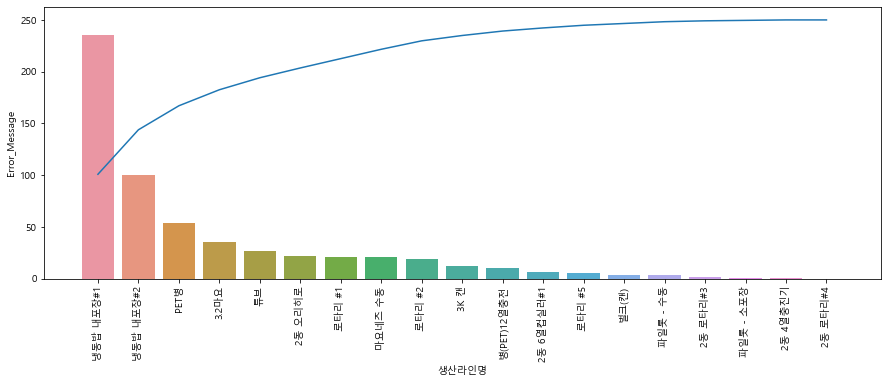

In [74]:
cook_error2 = cook_error.loc[cook_error.오류발생작업장명 == '충전실']
error_p = cook_error2.pivot_table(index='생산라인명', values='Error_Message', aggfunc='count').sort_values(by='Error_Message', ascending=False).reset_index()
error_p['누적합'] = error_p.Error_Message.cumsum()
error_p['누적비율'] = (error_p.누적합/582)*250

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,1,1)

ax = sns.barplot(data = error_p, x='생산라인명', y='Error_Message')
ax = sns.lineplot(data = error_p, x='생산라인명', y='누적비율')
plt.xticks(rotation=90)

### 쿠킹실 라인별 오류량

In [75]:
cook_error.오류발생작업장명.value_counts()
# cook_error2 = cook_error.loc[cook_error.오류발생작업장명 == '충전실']
# error_p = cook_error2.pivot_table(index='생산라인명', values='Error_Message', aggfunc='count').sort_values(by='Error_Message', ascending=False).reset_index()
# error_p['누적합'] = error_p.Error_Message.cumsum()
# error_p['누적비율'] = (error_p.누적합/368)*100

# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1,1,1)

# ax = sns.barplot(data = error_p, x='생산라인명', y='Error_Message')
# ax = sns.lineplot(data = error_p, x='생산라인명', y='누적비율')
# plt.xticks(rotation=90)


# 쿠킹실에서의 오류는 없음

충전실    586
쿠킹실    369
포장실    103
계량실     12
Name: 오류발생작업장명, dtype: int64

### 품목 별 오류 발생량

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

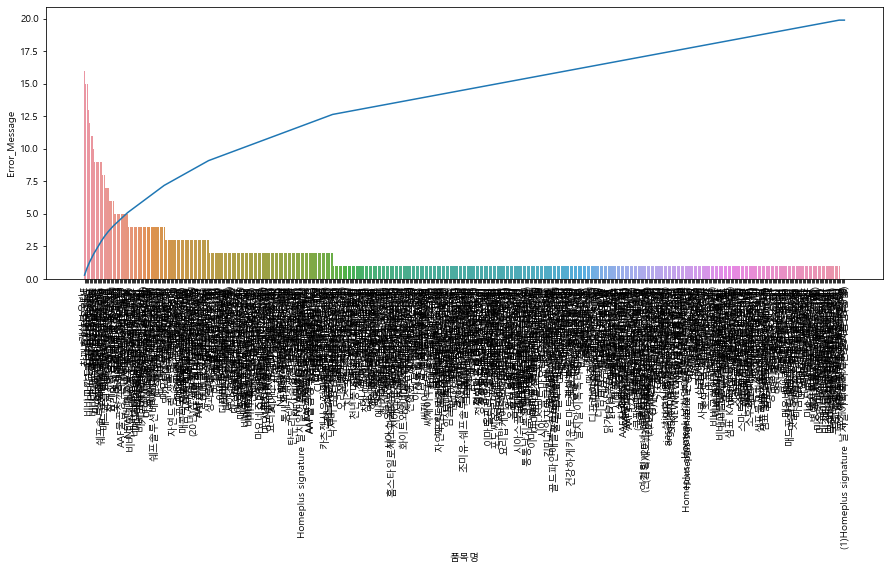

In [76]:
error_p = cook_error.pivot_table(index='품목명', values='Error_Message', aggfunc='count').sort_values(by='Error_Message', ascending=False).reset_index()
error_p['누적합'] = error_p.Error_Message.cumsum()
error_p['누적비율'] = (error_p.누적합/1070)*20

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,1,1)

ax = sns.barplot(data = error_p, x='품목명', y='Error_Message')
ax = sns.lineplot(data = error_p, x='품목명', y='누적비율')
plt.xticks(rotation=90)

### 공정별 에러량 pie

([<matplotlib.patches.Wedge at 0x2650d0b1430>,
 [Text(1.0993109030438202, 0.03892991714582404, '계량실'),
  Text(-0.23663137203872003, 1.0742465237398133, '충전실'),
  Text(-0.13432473203949233, -1.091767771260225, '쿠킹실'),
  Text(1.0496158054744635, -0.3290997734702853, '포장실')],
 [Text(0.5996241289329928, 0.021234500261358567, '1%'),
  Text(-0.12907165747566546, 0.5859526493126254, '55%'),
  Text(-0.0732680356579049, -0.5955096934146681, '35%'),
  Text(0.5725177120769801, -0.17950896734742833, '10%')])

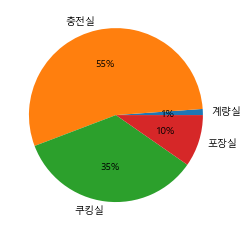

In [77]:
# 공정별 에러량
p2 = cook_error.pivot_table(index='오류발생작업장명', values='Error_Message', aggfunc='count')
p2['바율'] = p2.Error_Message/1065
p2.reset_index(inplace=True)
plt.pie(p2.Error_Message.values.tolist(), labels = p2.오류발생작업장명.values.tolist(), autopct='%.0f%%')

# cooking, cook_error 병합  =>  기계결함오류(Y) 표시  :  left join

In [78]:
cooking['생산일자'] = pd.to_datetime(cooking.생산일자)
cook_error_2 = pd.merge(cooking, cook_error, on = ['순번', '생산라인코드', '생산라인명', '생산일자', '품목코드', '품목명', '작업장코드', '충전실온도', '실링온도', '쿠킹온도', '쿠킹스팀압력', '실링압력', '생산시간'], how='left')
cook_error_2.기계결함오류.fillna('False', inplace=True)
cook_error_2.head(2)

,순번,생산라인코드,생산라인명,생산일자,품목코드,품목명,작업장코드,충전실온도,실링온도,쿠킹온도,...,실링압력,생산시간,발생시간,종료시간,오류조치시간,비가동코드,Error_Message,오류발생작업장명,re_오류조치시간,기계결함오류
0,3,C001,쿠커 #1,2011-01-03,23K01312,서비스면양념장(재),W003,71.669853,96.769853,131.742003,...,201.844,70.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,C002,쿠커 #2,2011-01-03,23V00019,고구마샐러드믹스베이스(재),W003,70.386480,102.086480,136.926080,...,212.043,70.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [79]:
cook_error_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24069 entries, 0 to 24068
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   순번             24069 non-null  int64         
 1   생산라인코드         24069 non-null  object        
 2   생산라인명          24069 non-null  object        
 3   생산일자           24069 non-null  datetime64[ns]
 4   품목코드           24031 non-null  object        
 5   품목명            24012 non-null  object        
 6   작업장코드          24069 non-null  object        
 7   충전실온도          24069 non-null  float64       
 8   실링온도           24041 non-null  float64       
 9   쿠킹온도           24041 non-null  float64       
 10  쿠킹스팀압력         24069 non-null  float64       
 11  실링압력           24069 non-null  float64       
 12  생산시간           22995 non-null  float64       
 13  발생시간           1070 non-null   object        
 14  종료시간           1070 non-null   object        
 15  오류조치시간         1070

# Booking data 전처리
- 납기일자가 정상적인 날짜로 들어오지 않은 경우, 분석대상에서 제외
  - +  19000100인 경우, 납기 실패가 나온 적 없는 기간에 수주를 받았기 때문에 분석 대상에서 제외한다.
- 수주 사업장 타입을 범주형으로 변환
- 수주일자 날짜 타입으로 변환

In [80]:
booking = pd.read_csv('./booking_data.csv')
# 전처리 
# 잘못된 납기일자 제외
lst = ['30180430','2018--0-5-', '43616','2018-05-','6월 5일','6월 12일','2018-061','0','2015-02-']

# 데이트타임으로 변환
def func1(x):
  x = str(x)
  if len(x) != 8:
    return x.split('.')[0]
  else:
    return x

booking = booking.dropna()
booking['납기일자(clean0)'] = booking['납기일자'].apply(func1)
booking['납기일자(clean1)'] = booking['납기일자(clean0)'].loc[~(booking['납기일자(clean0)'].isin(lst))].astype(int)

cond1 = (booking['납기일자(clean1)']>19900101) & (booking['납기일자(clean1)']<20221017) 
booking = booking.loc[cond1]
booking['납기일자_dt'] = pd.to_datetime(booking['납기일자'],format='%Y%m%d')
booking.drop(columns=['납기일자(clean0)', '납기일자(clean1)'], inplace=True)

# 수주사업장 범주형 타입 만들기
booking['수주사업장_cate'] = booking.수주사업장.astype('str')
booking['수주사업장_cate'] = booking['수주사업장_cate'].apply(lambda x : x + '번 사업장')

# - 수주일자 날짜 타입으로 변환
booking = booking.loc[~(booking.수주일자 == 0)]
booking['수주일자'] = pd.to_datetime(booking['수주일자'].apply(str), format='%Y-%m-%d')
booking.head(3)

# cooking 품목코드에 있는 수주품목코드만 남기기  원본 수주 데이터  :  1757237개  ->  1146778(1051865)
product_code = product.품목코드.unique().tolist()
booking_product = booking.loc[booking.수주품목코드.isin(product_code)]
booking_product.drop(index = [702964,853671], inplace=True)
booking_product.info()

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_8108\4277361317.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  booking = pd.read_csv('./booking_data.csv')
C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_8108\4277361317.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booking['납기일자(clean0)'] = booking['납기일자'].apply(func1)
C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_8108\4277361317.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booking_product.drop(index = [702964,853671], inplace=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051865 entries, 3 to 1757236
Data columns (total 19 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   수주사업장       1051865 non-null  float64       
 1   수주일자        1051865 non-null  datetime64[ns]
 2   수주일련번호      1051865 non-null  int64         
 3   거래처코드       1051865 non-null  object        
 4   수주부서        1051865 non-null  object        
 5   수주품목코드      1051865 non-null  object        
 6   수주단위        1051865 non-null  object        
 7   출고수량KG      1051865 non-null  float64       
 8   수주수량KG      1051865 non-null  float64       
 9   수주단가        1051865 non-null  float64       
 10  수주금액        1051865 non-null  float64       
 11  부가세금액       1051865 non-null  int64         
 12  출하완료여부      1051865 non-null  object        
 13  납기일자        1051865 non-null  object        
 14  기준단가        1051865 non-null  float64       
 15  생산지시        1051865 non-null  ob

# booking 데이터와 cooking 데이터로 공정별 생산 라인에 걸린 하루 부하 용량을 계산해보자
- 제대로 기입된 납기일자가 거의 없는 것 같음  =>  하루 부하 구할 수 있으려나,,

### 하루 부하를 구하긴 어려울 것 같고, `월별`로 해보자.

In [81]:
booking = booking_product

### 1.  booking과 cooking에서 '년도-월'을 추출해서 칼럼을 만들자

In [82]:
booking['생산년월'] = booking.수주일자.apply(lambda x: str(x)[:7])
booking.head(2)

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,출하완료여부,납기일자,기준단가,생산지시,수주수량,납기일자_dt,수주사업장_cate,생산년월
3,60.0,2015-12-14,441,SI0298,sc600,16A01039,EA,5.0,5.0,3630.0,16500.0,1650,Y,20151215,3630.0,N,5.0,2015-12-15,60.0번 사업장,2015-12
8,60.0,2015-12-14,453,SI0346,sc600,1BA03005,EA,9.0,9.0,1470.0,40091.0,4009,Y,20151215,1470.0,N,30.0,2015-12-15,60.0번 사업장,2015-12


In [83]:
cook_error_2['생산년월'] = cook_error_2.생산일자.apply(lambda x : str(x)[:7])
cook_error_2.head(2)

,순번,생산라인코드,생산라인명,생산일자,품목코드,품목명,작업장코드,충전실온도,실링온도,쿠킹온도,...,생산시간,발생시간,종료시간,오류조치시간,비가동코드,Error_Message,오류발생작업장명,re_오류조치시간,기계결함오류,생산년월
0,3,C001,쿠커 #1,2011-01-03,23K01312,서비스면양념장(재),W003,71.669853,96.769853,131.742003,...,70.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2011-01
1,1,C002,쿠커 #2,2011-01-03,23V00019,고구마샐러드믹스베이스(재),W003,70.386480,102.086480,136.926080,...,70.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2011-01


### 2. 필요한 변수 뽑기 & 병합

In [84]:
booking2 = booking[['생산년월', '수주품목코드', '수주단위', '출고수량KG']]
booking2.rename(columns={'수주품목코드' : '품목코드'}, inplace=True)
cooking2 = cook_error_2[['생산년월', '작업장코드', '생산라인코드', '품목코드']]

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_8108\433303987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booking2.rename(columns={'수주품목코드' : '품목코드'}, inplace=True)


In [85]:
df = pd.merge(booking2, cooking2, on=['생산년월', '품목코드'],how='inner')
df.pivot_table(index=['생산년월', '작업장코드', '생산라인코드', '품목코드'], values='출고수량KG', aggfunc='sum')

출고수량KG
생산년월    작업장코드 생산라인코드 품목코드                
2011-01 W005  D001   13P02106  104400.000
                     13S01017    5403.000
              D002   13A00388    1080.000
              D003   13A00418    1108.800
                     13A00424    2764.800
...                                   ...
2021-10 W007  P004   13D02345    9001.575
              P005   16B06084     492.800
              P006   13L00038    2327.640
                     16B06100    2526.000
              P0F0   13D02339    6490.125

[5163 rows x 1 columns]

In [86]:
df = pd.merge(booking2, cooking2, on=['생산년월', '품목코드'],how='inner')
df2 = df.pivot_table(index=['생산년월', '작업장코드', '생산라인코드', '품목코드'], values='출고수량KG', aggfunc='sum').reset_index()
df2['일평균출고수량'] = df2['출고수량KG']/30
df2 = df2[['생산년월', '작업장코드', '생산라인코드','품목코드', '일평균출고수량']]
df2

,생산년월,작업장코드,생산라인코드,품목코드,일평균출고수량
0,2011-01,W005,D001,13P02106,3480.000000
1,2011-01,W005,D001,13S01017,180.100000
2,2011-01,W005,D002,13A00388,36.000000
3,2011-01,W005,D003,13A00418,36.960000
4,2011-01,W005,D003,13A00424,92.160000
...,...,...,...,...,...
5158,2021-10,W007,P004,13D02345,300.052500
5159,2021-10,W007,P005,16B06084,16.426667
5160,2021-10,W007,P006,13L00038,77.588000
5161,2021-10,W007,P006,16B06100,84.200000


In [87]:
df2.columns

Index(['생산년월', '작업장코드', '생산라인코드', '품목코드', '일평균출고수량'], dtype='object')

#### cooking에서 라인의 제품별 생산량을 구해보자

In [88]:
df2 = pd.merge(cook_error_2, df2, on=['생산년월', '작업장코드', '생산라인코드', '품목코드'], how='inner')
df2.columns

Index(['순번', '생산라인코드', '생산라인명', '생산일자', '품목코드', '품목명', '작업장코드', '충전실온도',
       '실링온도', '쿠킹온도', '쿠킹스팀압력', '실링압력', '생산시간', '발생시간', '종료시간', '오류조치시간',
       '비가동코드', 'Error_Message', '오류발생작업장명', 're_오류조치시간', '기계결함오류', '생산년월',
       '일평균출고수량'],
      dtype='object')

In [89]:
df2.isna().sum()

순번                   0
생산라인코드               0
생산라인명                0
생산일자                 0
품목코드                 0
품목명                  4
작업장코드                0
충전실온도                0
실링온도                 9
쿠킹온도                 9
쿠킹스팀압력               0
실링압력                 0
생산시간               472
발생시간             10034
종료시간             10034
오류조치시간           10034
비가동코드            10034
Error_Message    10036
오류발생작업장명         10034
re_오류조치시간        10034
기계결함오류               0
생산년월                 0
일평균출고수량              0
dtype: int64

In [90]:
cook_error_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24069 entries, 0 to 24068
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   순번             24069 non-null  int64         
 1   생산라인코드         24069 non-null  object        
 2   생산라인명          24069 non-null  object        
 3   생산일자           24069 non-null  datetime64[ns]
 4   품목코드           24031 non-null  object        
 5   품목명            24012 non-null  object        
 6   작업장코드          24069 non-null  object        
 7   충전실온도          24069 non-null  float64       
 8   실링온도           24041 non-null  float64       
 9   쿠킹온도           24041 non-null  float64       
 10  쿠킹스팀압력         24069 non-null  float64       
 11  실링압력           24069 non-null  float64       
 12  생산시간           22995 non-null  float64       
 13  발생시간           1070 non-null   object        
 14  종료시간           1070 non-null   object        
 15  오류조치시간         1070

In [91]:
cook_error_2['Y_num'] = cook_error_2['기계결함오류'].apply(lambda x : 1 if x == 'True' else 0)

In [92]:
cook_error_2.columns

Index(['순번', '생산라인코드', '생산라인명', '생산일자', '품목코드', '품목명', '작업장코드', '충전실온도',
       '실링온도', '쿠킹온도', '쿠킹스팀압력', '실링압력', '생산시간', '발생시간', '종료시간', '오류조치시간',
       '비가동코드', 'Error_Message', '오류발생작업장명', 're_오류조치시간', '기계결함오류', '생산년월',
       'Y_num'],
      dtype='object')

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


from imblearn.over_sampling import SMOTE, SMOTENC

# model
from sklearn.linear_model import LogisticRegression     # True       0.57      0.28      0.37       138
from sklearn.naive_bayes import GaussianNB              # True       0.16      1.00      0.28       130
from sklearn.neighbors import KNeighborsClassifier      # True       0.58      0.52      0.55       131
# from sklearn.svm import SVC     :   처참한 결과
from sklearn.tree import DecisionTreeClassifier       # True       0.53      0.56      0.54       154
from sklearn.ensemble import RandomForestClassifier     # True       0.46      0.66      0.54       120



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

In [94]:
# y값을 0, 1로 해서 DecisionTreeRegressor로 해보자,,

x_list = ['작업장코드', '실링온도', '쿠킹온도', '쿠킹스팀압력', '실링압력']

X = cook_error_2[x_list].fillna(0)
Y = cook_error_2['Y_num']

X.작업장코드 = X.작업장코드.astype('string')
# X.생산라인코드 = X.생산라인코드.astype('string')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

sm = SMOTENC(categorical_features=[0,1], k_neighbors=1 ,random_state = 2,sampling_strategy = 'minority')
X_train, Y_train = sm.fit_resample(X_train, Y_train)



numeric_pipe = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
catagory_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

numeric_list = X.describe().columns.to_list()
category_list = X.describe(include='string').columns.to_list()

preprocess_pipe = make_column_transformer((numeric_pipe, numeric_list),(catagory_pipe, category_list))

model_pipe = make_pipeline(preprocess_pipe, RandomForestClassifier())

hyperparameter = {
                    # 'bootstrap': [True]
                    # ,'max_depth': range(5, 10)
                    # ,'max_features': [2, 3]
                    # ,'min_samples_leaf': [3, 4, 5]
                    # ,'min_samples_split': [8, 10, 12]
                    # ,'n_estimators': [100, 200, 300, 1000]
                }
grid_model = GridSearchCV(model_pipe, param_grid=hyperparameter, cv=5, n_jobs=-1)

grid_model.fit(X_train, Y_train)

best_model = grid_model.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [95]:
# 초매개변수 설정 x
print("성능..?")
print(classification_report(Y_train, Y_train_pred))
print('-------------------------------------')
print("일반화")
print(classification_report(Y_test, Y_test_pred))

성능..?
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17722
           1       1.00      1.00      1.00     17722

    accuracy                           1.00     35444
   macro avg       1.00      1.00      1.00     35444
weighted avg       1.00      1.00      1.00     35444

-------------------------------------
일반화
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5891
           1       0.46      0.56      0.51       127

    accuracy                           0.98      6018
   macro avg       0.73      0.77      0.75      6018
weighted avg       0.98      0.98      0.98      6018



# 충전실 기계결함 에러 예측
- 디코에 있는 pair plot 기반  =>  실링온도와 쿠킹온도는 완전한 선형성을 보임  =>  모델에는 하나의 값만 넣도록 하자

In [100]:
bigcate = {'밥류' : [ '마오나게살볶음밥', 'Homeplus signature 날치알이톡톡터지는날치알밥',   'Homeplussignature 곤드레버섯나물밥', '(쿠팡)곰곰차돌깍두기볶음밥', '병아리콩잡곡밥 3kg(도시락용)','게살볶음밥E', '쉐프솔루션베이스볶음밥(시즌)500g', '비비고불고기비빔밥200g', '비비고새우볶음밥210g(알밥)', '비비고깍두기볶음밥200g', '김치볶음밥-S', '비비고곤드레밥200g', 'NEW비비고새우볶음밥210g(알밥)', '비비고낙지비빔밥200g', 'AAF게살새우볶음밥(알밥)*', '한가득낙지볶음밥', 'AAF불곱창깍두기볶음밥250g(알밥)*', '홍익돈까스 야채볶음밥', '비비고닭가슴살볶음밥210g(알밥)', '매콤낙지볶음밥(노브랜드)', '마왕갈릭라이스', 'CJ햄야채볶음밥3kg', '한가득중화풍볶음밥', '통새우볶음밥(노브랜드)', '매드포갈릭갈릭버터라이스200g', '비비고소고기볶음밥200g(알밥)', '비비고닭갈비볶음밥(알밥)', '굴소스로맛을낸게살새우볶음밥', 'CJ새우볶음밥/20개입', '볶음밥베이스E', 'CJ해물볶음밥/20개입', '비비고햄야채볶음밥200g(알밥)', 'Homeplus signature 낙지볶음밥(알밥)', '매드포갈릭갈릭버터라이스300g', '(쿠팡)곰곰소불고기볶음밥', '(쿠팡)곰곰간장버터새우볶음밥', '매콤낙지볶음밥(노브랜드)/7개입', '옥수수볶음밥JB 1kg', 'CJ낙지볶음밥*5ea', 'AAF치즈불고기볶음밥(알밥)', 'CJ낙지볶음밥/20개입', 'CJ새우볶음밥*5ea', '통새우볶음밥(노브랜드)/7개입', 'CJ새우볶음밥3kg', '(쿠팡)곰곰닭갈비볶음밥', '낙지쭈꾸미볶음밥', '게살볶음밥-F', 'CJ햄야채볶음밥/20개입', '한그릇연근우엉밥3kg', '비비고취나물밥200g', '쟌슨빌소시지볶음밥(알밥)', 'Homeplus signature 불곱창깍두기볶음밥(알밥)', '시아스야채볶음밥3kg', 'Homeplus signature 곤드레버섯나물밥(알밥)', '비비고시래기나물밥200g', 'The 통통한 낙지볶음밥', '닭가슴살볶음밥(노브랜드)', 'CJ김치볶음밥(수출용)', '탄두리닭가슴살현미볶음밥H 5kg', '애슐리갈릭스테이크볶음밥', '콩콩푸드밥5kg', 'CJ햄야채볶음밥*5ea', '땡초상하이볶음밥', '갈릭라이스3kg', '날치알이톡톡터지는알밥(알밥)', 'Homeplus signature 날치알이톡톡터지는날치알밥(알밥)', '매운곱창철판볶음밥', '(쿠팡)곰곰대패삼겹볶음밥', '닭가슴살볶음밥(노브랜드)/7개입', '쫄깃매콤낙지볶음밥', '하남돼지집김치볶음밥', '강원나물밥200g(알밥)', 'AAF장조림볶음밥(알밥)*', '매운곱창볶음밥', '새우볶음밥-F', 'Sias새우볶음밥', '장조림버터밥(롯데)', '취나물현미밥5kg', 'Homeplus signature 소불고기볶음밥', 'AAF곤드레나물밥(알밥)-NEW', '치즈스테이크볶음밥', 'AAF곤드레나물밥250g(알밥)*', 'CJ해물볶음밥*5ea', '요리하다해물철판볶음밥', 'Homeplus signature 새우볶음밥', '리얼통새우볶음밥', '비비고불고기비빔밥(EMT)/알밥', '셰프리볶음밥', '샤이바나베이스밥', '엑소게살새우볶음밥', '(쿠팡)곰곰잡채볶음밥', '비비고새우볶음밥(홈플)', '보리리조또베이스E', '비비고닭가슴살볶음밥(홈플)', '팔도야채볶음밥(알밥)', '곤드레나물밥H5kg', 'NEW햄야채볶음밥300g', '한끼든든김치볶음밥', 'NEW새우볶음밥300g', '요리하다오삼불고기볶음밥', '탄두리닭가슴살현미볶음밥10kg', '한끼든든새우볶음밥', '세가지나물영양밥5kg(도시락용)', '후레시스김치볶음밥', 'AAF3가지나물밥250g(알밥)*', '새우볶음밥300g', '감자탕볶음밥', 'NEW비비고새우볶음밥(홈플)', '비비고불고기비빔밥(밥,참기름)-컵', '중화풍볶음밥-C', '무명식당뿌리채소영양밥5kg', '비비고강된장보리비빔밥(감자보리밥)(알밥)', '프리미엄황금볶음밥', 'NEW치킨데리야끼볶음밥300g', '팔도산채나물밥(알밥)', '야채현미밥H5kg', '시아스햄야채볶음밥(핫딜)', '철판직화볶음밥', '위즈메택김치볶음밥', '춘천식닭갈비볶음밥', '게살볶음밥1kg', '탄두리치킨볶음밥(도시락용)', 'NEW소불고기볶음밥300g', 'NEW낙지볶음밥300g', '굿프랜즈치즈불고기볶음밥', '담두햄야채볶음밥', '담백닭가슴살볶음밥', '애슐리깍두기치즈볶음밥', '비비고불고기비빔밥/알밥(롯데)', '퀴노아렌틸콩현미볶음밥5kg', '탄두리닭가슴살현미볶음밥1kg', '야채현미밥H1kg', '위즈메택불고기맛볶음밥', '찰현미새우볶음밥5kg', '해물철판볶음밥', 'NEW야채볶음밥베이스3kg', '야채볶음밥베이스3kg', '타이풍볶음밥E', 'AAF게살새우볶음밥(미니팩)', '위즈메택새우볶음밥', '하나로햄야채볶음밥', '병아리콩잡곡밥(도시락용)', 'CJ깍두기볶음밥(에쓰닉)', '보리귀리렌틸콩밥E', 'NEW게살볶음밥300g', '애슐리통새우볶음밥', '게살새우볶음밥', '스파게티스토리볶음밥', '버터라이스 1.1kg', '김가루밥패티용냉동밥', '짬뽕볶음밥E', '타코볶음밥1kg', '철판직화김치볶음밥', '장조림라이스E 1kg', '낙지볶음밥300g', '무명식당3종나물영양밥(알밥)', '(1)김치볶음밥S 3kg', '오늘은!새우볶음밥', '(1)게살볶음밥E', '(쿠팡)곰곰갈비맛치킨밥', '야채현미밥H10kg', '(쿡)병아리콩잡곡밥1kg', '김치볶음밥300g', '하나로새우볶음밥', '콩콩푸드밥3kg', '전주식비빔밥(알밥)', 'NEW김치볶음밥300g', '문어베이스밥', '소후레쉬야채볶음밥3kg', '(쿡)퀴노아렌틸잡곡밥1kg', '퀴노아렌틸콩잡곡밥(도시락용)', '쿠캣감자탕볶음밥', '날치알밥베이스', '소불고기볶음밥300g', '중국집볶음밥(알밥)', '곤드레나물밥-H', '어수리나물밥5kg', 'AAF불곱창깍두기볶음밥(밥,김가루)*', '요리밥상하이필라프250g', '비비고햄야채볶음밥(200g)', '짬뽕볶음밥(시아스)', '담두새우볶음밥', '찰보리버터향리조또E', 'AAF불곱창깍두기볶음밥(미니팩)', '비비고소고기볶음밥(200g)', '새우볶음밥-S 200g', '엄지김치볶음밥 300g', '깍두기밥5kg', '요리하다낙지쭈꾸미볶음밥', '현미밥-SH', 'CJ새우볶음밥(에쓰닉)', '직화새우볶음밥용냉동밥', '햄야채볶음밥300g', '부드러운새우볶음밥3kg', '햄야채볶음밥3kg', 'CJ새우볶음밥(수출용-costco)', '쟌슨빌소시지볶음밥(미니팩)', '직화김치볶음밥용냉동밥', '취나물현미밥10kg', 'NEW해물볶음밥300g', '무명식당돈육장조림비빔밥(알밥)', '비비고소고기볶음밥(홈플)', '(1)강원나물밥200g(알밥)', '엄지알리올리볶음밥 3kg', 'AAF장조림볶음밥*', '(쿡)시아스야채볶음밥1kg', '오삼불고기볶음밥(시아스)', '갈릭시즐링라이스 3kg', '한입밥용냉동밥', '하나로해물볶음밥', '불고기한입밥용냉동밥', '1974새우볶음밥240g', '(21년)NEW김치볶음밥300g', '강원나물밥H', '커리용게살새우볶음밥', '담두낙지볶음밥', '치즈불닭볶음밥', '어수리나물밥10kg', '퀴노아렌틸콩현미볶음밥1kg', '(1)애슐리갈릭스테이크볶음밥', '요리밥치킨리조또라이스250g', 'AAF치즈불고기볶음밥(미니팩)', '철판새우볶음밥', '김치볶음밥3kg', '담두김치볶음밥', '치킨데리야끼볶음밥300g', '흑미밥-쿡', '(1)NEW새우볶음밥300g(칼로스쌀)', '리조또용베이스밥-B', '(1)한그릇연근우엉밥(혼합미)', '곤드레나물밥H10kg', '(1)애슐리통새우볶음밥', '무명식당뿌리채소영양밥(알밥)', '엄지새우볶음밥 300g', '흑미밥-S(3KG)', '취나물현미밥1kg', '요리밥케이준스파이스필라프750g', '찰현미새우볶음밥3kg', '(쿡)산들나물밥1kg', '게살볶음밥300g', '콩콩푸드밥10kg', '엄지계란볶음밥 3kg', '황금볶음밥-FN', '(쿡)한그릇연근우엉밥1kg', '베이스밥-S', '매운곱창볶음밥(2번들)', '갈릭&포크 황금볶음밥', '비비고불고기비빔밥(롯데)', '통통낙지볶음밥(도시락용-자사생산)', '데리야끼볶음밥-G', '짐키친 강황베이스밥', '(쿡)탄두리치킨볶음밥1kg', '흰쌀베이스밥', '김치삼겹볶음밥300g', '산들나물밥(도시락용)', '김치볶음밥250g-QKC', '갈릭시즐링라이스5kg', '어수리나물밥', '오양치킨데리야끼볶음밥', '요리밥리조또라이스-로제토마토250g', '오양낙지볶음밥', '무명식당뿌리채소영양밥3kg', '요리밥케이준스파이스필라프250g', '베베쿡어린이볶음밥닭가슴살과병아리콩', '김민교의사와디밥불고기볶음밥', '(쿠팡)곰곰활화산치킨밥', '비비고닭가슴살볶음밥420g', '비비고새우볶음밥(롯데)', '철판게살볶음밥', '갈릭라이스S 200g', '요리밥상하이필라프750g', '철판닭가슴살볶음밥', '풀잎채라이스', '찰현미새우볶음밥10kg', 'AAF치즈불고기볶음밥/스탠딩파우치', '해물볶음밥300g', "Single's_pride간편하게즐기는통새우볶음밥920g", '더맛있는새우볶음밥230g*2ea', '불고기맛볶음밥250g-QKC', 'AAF게살새우볶음밥/스탠딩파우치', '치킨데리야끼볶음밥-S 200g', '새우볶음밥T(알밥)', '김치볶음밥T(알밥)', '대삼식당삼겹김치볶음밥', '야채곱창볶음밥', '통통낙지볶음밥 3kg(도시락용-자사생산)', '햄야채볶음밥1kg', '현미전복죽(컵)260g', '하나로치킨데리야끼볶음밥', '더맛있는소시지볶음밥230g*2ea', 'SF김치볶음밥', '박가부대닭갈비볶음밥 200g', '엄지김치볶음밥 3kg', '요리밥열을뿜는낙지볶음밥250g', '춘천닭갈비볶음밥3kg', '커리용닭가슴살볶음밥', '비비고새우볶음밥/알밥(롯데)', '은행마늘찹쌀라이스', '괴짜파스타필라프용밥(300g)', '콩콩푸드밥1kg', '오곡삼계죽(컵)260g', '한그릇연근우엉밥', '남도분식 짜짱 떡볶밥(알밥)', '시아스베이스밥', '큼직한새알동지팥죽', '괴짜파스타리조또용밥(200g)', '명품필라프용밥', '(쿡)세가지나물영양밥1kg', '병아리콩베이스밥3kg', 'Homeplus signature 날치알이톡톡터지는날치알밥(HDS)-알밥', 'AAF게살새우볶음밥*', '비비고불고기비빔밥403g*2ea', '김치삼각밥용 볶음T', '찰보리버터향리조또K', '프리가베이스밥1kg', '철판상하이볶음밥', '(쿠팡)곰곰포크&스크램블볶음밥', 'Homeplus signature 낙지볶음밥', '퀴노아렌틸콩현미볶음밥T', '(마켓컬리)sias닭가슴살볶음밥', '1974양송이버섯볶음밥240g', '깍두기볶음밥E', '김민교의사와디밥햄김치볶음밥', '김민교의사와디밥돼지고기바질볶음밥', '요리밥부드러운새우볶음밥250g', 'TMI김치볶음밥', '비비고햄야채볶음밥(홈플)', '철판야채볶음밥', '퀴노아렌틸콩현미볶음밥10kg', '황금볶음밥T 210g', '식자재왕/새우볶음밥', 'NEW비비고새우볶음밥/알밥(롯데)', '오양소불고기볶음밥', '오양햄야채볶음밥', '하나로돈육짜장볶음밥', '잡채볶음밥250g-QKC', '요리하다해물철판볶음밥750g', '마음심은곱창깍두기볶음밥', '마음심은장조림볶음밥', '오늘은!갈릭볶음밥', '햄야채볶음밥-S 200g', '새우명란볶음밥', '삼겹볶음밥300g', '비비고깍두기볶음밥(김,참깨와고명)', 'Homeplus signature 낙지볶음밥(HDS)-알밥', '(1)애슐리깍두기치즈볶음밥', '엄지묵은지삼겹볶음밥 300g', '세미계파김치닭가슴살볶음밥(알밥)', '곰곰마늘이들어간스테이크볶음밥', 'NEW야채볶음밥', '씨름제육볶음밥', '(2)애슐리통새우볶음밥', 'SF베이컨김치볶음밥', '분식문방구김치볶음밥', '씨름김치볶음밥', '전복볶음밥', '(1)Homeplus signature 날치알이톡톡터지는날치알밥(알밥)', '신세계찹쌀쇠고기죽(260g)', '맛있는한끼단호박죽', '비비고햄야채볶음밥(EMT)', '단호박죽280g', '신세계얼큰짬뽕맛김치죽(260g)', '불짬뽕볶음밥', '우미학차돌된장밥', '오양새우볶음밥', '오양김치볶음밥', '세가지나물영양밥 3kg(도시락용)', '(1)Homeplus signature날치알이톡톡터지는날치알밥(밥+후리가', '리조또용베이스밥', '시아스야채볶음밥1kg', '오곡삼계죽(컵)260g*6ea', '귀리소고기죽(컵)260g', '무명식당3종나물영양밥(밥,간장)', '게살장볶음밥', '(1)NEW햄야채볶음밥300g(칼로스쌀)', '중화볶음밥-FN', '마왕갈릭라이스-S', '마음심은불고기볶음밥', '마음심은갈릭버터새우볶음밥', '깍두기볶음밥용소스18kg', '쿠마이쉬림프후라이드라이스2kg', '피코크사골소고기야채죽', '쿠마이악토퍼스후라이드라이스2kg', '쟌슨빌소시지볶음밥', '정다래햄야채볶음밥', '무명식당돈육장조림비빔밥', '게살볶음밥250g-QKC', '귀리소고기죽(컵)260g*6ea', 'NEW비비고새우볶음밥(롯데)', '시래기밥', '(쿡)통통낙지볶음밥 1kg', '퀴노아렌틸콩잡곡밥 3kg(도시락용)', '하나로치킨카레볶음밥', '김민교의사와디밥파인애플볶음밥', '엄지치킨데리야끼볶음밥 3kg', '베베쿡어린이볶음밥새우와렌틸콩', '베베쿡어린이볶음밥베이컨과퀴노아', '탄두리치킨볶음밥 3kg(도시락용)', '볶음밥용매콤소스', '팔도비빔밥-산채나물(홈플)', '비비고시래기나물밥(밥,씨앗강된장,들기름)', '요리하다오징어김치볶음밥', '요리하다제육볶음밥', '팔도비빔밥-진짜짜장', '엄지야채볶음밥 3kg', '비비고불고기비빔밥(TD)', '(쿠팡)곰곰소고기버섯볶음밥', '프레시지만능볶음밥', 'GS무명식당3종나물영양밥(밥,간장)', '굿프랜즈치즈닭갈비볶음밥', '쉐프현닭가슴살볶음밥 3kg', '우리쌀볶음밥 3kg', '김민교의사와디밥게살볶음밥', '비비고새우볶음밥420g', '비비고깍두기볶음밥(홈플2번들)', '퀴노아렌틸콩현미볶음밥3kg', 'NEW비비고새우볶음밥420g*2ea', '비비고불고기비빔밥(밥,참기름)', 'Homeplus signature 새우볶음밥(HDS)', '오징어철판볶음밥-S', '조미유-쉐프솔루션베이스볶음밥(시즌)', '식자재왕/햄야채볶음밥', '햄야채볶음밥-L', 'TMI야채볶음밥', '흑미밥-SH', '현미찰보리밥10kg', '불곱창깍두기볶음밥-M', '비비고새우볶음밥420g*2ea', '나물향가득한곤드레나물밥240g', '치킨데리야끼볶음밥-L', '꽁시면관야채볶음밥'],
'소스류' : ['메론드레싱','뽀모도로스파게티소스100g','베이컨크림스파게티소스100g','샘표 KALBI SAUCE964g(미국수출)','무교동오징어낙지볶음양념130g',
                              '시아스올리브유오리엔탈드레싱975g', '멸치칼국수액상스프35g', '화이트와인비네거드레싱엔쵸비235g', '떡볶이양념E 2kg', '렌치치즈소스','샘표강된장양념',
                               'dip양념치킨소스/하림', '참깨베이스', '치즈소스J', 'organicstory유기농아가베시럽665g','골드마요네즈3.2kg', '해표골드마요네즈', '이츠웰골드마요네즈3.2kg', '참깨흑임자드레싱', '마요네즈-업소용10kg', '마요네즈-P(현미유)/국산난황', '아몬드호두드레싱', '미스터피자피자소스엠피', '소후레쉬마요네즈골드3.2kg', '레몬갈릭소스', '세서미오리엔탈드레싱', '디프라이스마요네즈500g', '스위트머스타드드레싱', '맛있는골드마요네즈3.2kg', '굴소스라이스(3kg)', '이츠웰골드마요네즈1kg', '올리브유발사믹드레싱', '피자스쿨마요네즈', '오리엔탈드레싱-N 240g', '디프라이스마요네즈튜브', '오리엔탈드레싱', '마요네즈-업소용18kg', '크리미시저드레싱', '신선하고깨끗한마요네즈', '오리엔탈드레싱225g', '1/2샐러드소스파인애플', '이마트 고소한 마요네즈515g', '요리愛[애]요리당', '골드마요네즈(업소용)10kg', '오리엔탈드레싱115g', '골드마요네즈3.2kg(캡파우치)', '산뜻한마요네즈250g', '참깨&흑임자드레싱-N 220g', '오리엔탈드레싱-N 550g', '미스터피자살사소스엠피', '챔케이준드레싱100g', '올리브유발사믹드레싱105g', '시아스샐러드마요-2(자사용)', 'JFC마요네즈1kg', '1/2플레인소스-현미유', '이마트베스트머스타드소스', '시아스골드마요네즈2kg-에스그린', '챔케이준드레싱250g', '스마트이팅칼로리를줄인머스타드', '디프라이스마요네즈-1 1kg', '아몬드&호두드레싱-N 225g', '이마트베스트돈까스소스', '참깨흑임자드레싱105g', '1/2샐러드소스 파인애플', '챔키위드레싱240g', '참깨&흑임자드레싱-N 495g', '이마트 고소한 마요네즈250g', '샘표불고기소스900g-광구', '샘표불고기소스900g-NEW(캐나다)', '마요네즈-제빵용18kg', '비비고낙지비빔밥(밥,소스)-컵', '허니머스타드드레싱-N 510g', '베스트셀렉트허브칠리595g', '토마토스파게티소스골드', '이마트허니머스타드드레싱280g', '아몬드&호두드레싱-N 495g', '맛있는골드마요네즈1kg', '오리엔탈드레싱-N 115g', '샘표매콤한떡볶이소스', '이마트베스트핫칠리소스', '베스트셀렉트머스타드520g', '치즈크림스파게티소스골드', '(20년)참깨&흑임자드레싱-N105g', '비프스파게티소스', '맘스양념소스2kg', '1/2샐러드소스키위', '식자재왕마요네즈3.2kg', '베스트셀렉트돈까스소스565g', '포도씨유로만든키위드레싱540g', '임실앤치즈피자소스', '발사믹올리브유드레싱235g', '(20년)참깨&흑임자드레싱-N220g', '참깨흑임자드레싱100g', '이마트베스트허브칠리소스', '가쓰오다시국물900ml', '초고추장E 200g', '구터스마요네즈골드1kg', '이마트베스트콜슬로우드레싱', '이마트베스트허브바베큐소스', '아몬드호두드레싱495g', '아몬드&호두드레싱-N 110g', '정성담은토마토케찹(595g)', 'KFC마요드레싱3kg', '안동찜닭양념210g', '엔젤코코소스', '양장피소스T', '시아스피자소스', '돈까스소스1.95kg', '자연드림 상큼한 토마토케찹595g', '천년풍미퓨어마요네즈', '1/2샐러드소스 키위', '빠네크림소스T', '1/2샐러드소스 스트로베리', '쉐프메이드세서미오리엔탈', 'G-price마요네즈500g', '이마트돈까스소스600g', '마요네즈P(현미유)/중국산난황', '(20년)아몬드&호두드레싱-N495*2', 'BK디아블로소스(1kg)', '참깨&흑임자드레싱-N 105g', '서비스면양념장', '프리미엄오리엔탈드레싱1kg', '요리愛[애]허니머스타드소스', '참깨흑임자드레싱-P', '치즈소스-BK', '정성담은마요네즈18kg', '스위트머스타드드레싱510g', '멸치볶음소스300g', '스마트이팅칼로리를줄인허브칠리소스', '바른선유정란마요네즈3kg(부스터사용)', 'Sias유자드레싱1025g', '임실치즈피자비프스파게티소스', '이마트 야채케챱600g', '포도씨유로만든파인애플드레싱545g', '비비큐소스', '이마트스테이크소스600g', '키위저지방샐러드소스-N 235g', '샘표불고기소스300g-신캐나다', '이마트가쓰오다시국물', '샘표안동찜닭소스', '이마트1000아일랜드드레싱540g', '이마트베스트스테이크소스', '마왕소스(순한맛)', '노브랜드핫칠리소스', '미스터피자마요네즈', '샘표불고기양념500g-중국', '요리愛[애]사우전아일랜드드레싱', '골드마요네즈(업소용)-T', '토마토케찹18kg', '참깨흑임자드레싱495g', '오뎅소스-R', '샘표불고기소스300g-독일', '정성담은토마토케찹(280g)', '천년풍미퓨어마요네즈1kg', '유기아가베시럽665g/올가홀', '올리브유발사믹드레싱525g', '디딤돌골드마요네즈3.2kg', '올리브유발사믹드레싱-P', '노브랜드머스타드소스', '노브랜드돈까스소스', '정성담은양념치킨소스(320g)', '마요네즈-업소용10kg(현진)', '홈스타일토마토스파게티소스/14일에이징출고', '참깨&아몬드드레싱495g', '요거트드레싱', '아몬드호두드레싱-P', '아몬드호두드레싱-P 495g', '허니머스타드드레싱-N 230g', '홈스타일오리엔탈드레싱', '발사믹올리브유드레싱110g', '허니브라운머스타드-E', '시아스사누끼우동소스', '에디슨양념치킨소스3.2kg', '1/2샐러드소스스트로베리', '임실앤치즈피자스파게티소스', '오리엔탈레몬소스', '이석민피자소스', '토마토케찹자사용', '유자마요네즈290g', '샘표불고기소스300g', '케이준샐러드드레싱', '포도씨유로만든블루베리드레싱540g', '샘표 BULGOGI SAUCE964g(미국수출)', '팔도만능비빔장', '정성담은마요네즈(250g)', '발사믹올리브유드레싱525g', 'KFC마요소스', '식자재왕마요네즈1kg', '정성담은마요네즈(1kg)', '샘표갈비소스300g-신캐나다', '와사비마요-H 10kg', '1/2키위샐러드소스-P', '소불고기소스-H', '초대리-B 20kg', '시아스피자소스-S', '1/2샐러드소스 키위115g', '소후레쉬마요네즈골드', '맛을더해주는허브칠리소스295g', '스위트머스타드-P', '홈플러스시그니처키위드레싱', '클래식시저드레싱220g', '트레이더스가쓰오다시국물', '단팥퐁듀소스3kg-E', 'Sias허브칠리소스1080g', '맛을더해주는타르타르소스245g', '용돈까스소스M', '안동찜닭양념210g/신', '샘표춘천닭갈비소스', '어니언크림소스-S', '참치액900ml', '토마토스파게티소스2.95kg', '시아스떡볶이양념소스-1', '핸드피자소스', '이마트베스트타르타르소스', '밀키마요네즈', '미스터피자치킨스파게티소스', '마요네즈S-1', '플레인소스-현미유', '이마트 야채케챱295g', '(20년)레몬갈릭샐러드소스-N110g', '(20년)참깨&흑임자드레싱-N495g', '바른선유정란마요네즈1kg(부스터사용)', '1/2파인애플샐러드소스-P', '(20년)허니머스타드드레싱-N510g', '오리엔탈소스100g', '마요네즈-업소용153kg', '샘표갈비소스900g-광구', '이마트그린키위드레싱580g', 'KFC마요드레싱전분부', '치킨샐러드드레싱', '네네마요네즈153kg', '바른선마요네즈3kg', '세서미오리엔탈드레싱2kg', '프리미엄키위드레싱', '카츠젠사우전아일랜드드레싱2kg', '마요네즈-제빵용/국산', '정성담은허니머스타드소스(260g)', '미스터피자블루베리시럽엠피', '크라제바베큐소스18kg', '키위저지방샐러드소스-N 115g', '안동찜닭양념210g/신(별미)', '오리지널멘츠카츠소스', '샘표갈비소스900g-NEW(캐나다)', '돈까스소스2kg(파우치)', '칠리소스-엠피(1kg)', '간편고추장소스', '허니머스타드소스골드', '스위트머스타드110g', '샘표갈비소스900g', '스테이크소스', '바른선요거트드레싱2kg', '스마트이팅1/2나트륨돈까스소스', '홈플러스시그니처참깨드레싱', '포도씨유로만든파인요거트드레싱495g', '명인떡볶이소스', '샘표불고기소스840g-미국', '쉐프메이드오리엔탈드레싱550g', '리얼과일애플망고저지방드레싱240g', '본뽀스또뽀모도로파스타소스', '레드와인드레싱', '생생마요네즈250g', '마왕소스(매운맛)', '토마토케찹153kg', '유기아가베시럽335g/올가홀', '갈릭레몬소스', '렌치드레싱485g', '비스테카스테이크소스', '치즈소스-R', '네네토마토케첩153kg', '이마트마요네즈300g', '시아스우동소스', '달콤한떡볶이소스', '시아스칠리소스12g', 'Sias허니브라운머스타드소스960g', '데미그라스소스-P', '키위드레싱골드', '타르타르소스골드2kg', '마요네즈(제빵용)/중국산', '토마토케찹2kg', '(20년)아몬드&호두드레싱-N225g', '요리가맛있어지는비법간장소스', '(20년)아몬드&호두드레싱-N495g', '이마트허니머스터드소스335g', '핫도그미트칠리소스-T', '시아스오리엔탈소스', '조이푸드할라피뇨바베큐소스18kg', '가쓰오우동다시', '샘표잘익은고추장에상큼한레몬초고추장', '샘표불고기소스540g-미국/6개입', '맛을더해주는머스타드소스520g', '사우전아일랜드-K', '유자마요네즈500g', '임실치즈피자소스골드-S', '샘표갈비소스964g', '맛을더해주는돈까스소스565g', '샐러드소스/올바른샐러드콘용(중국산)', '이태리식토마토스파게티소스', '맘스스위트양념소스', '간장양념치킨소스2kg', '시아스고구마소스', '프리미엄유기농아가베시럽665g/이마트', '원할머니기자미소스', '갈비양념(홈플)', '골드마요네즈3.2kg-수출', '샘표핫갈비소스900g-NEW(캐나다)', '비빔장360g', '춘천닭갈비양념180g', '매운데리야끼소스-R', '샘표불고기소스500g', '시아스비프스파게티소스1kg', '스위트머스타드-P 510g', '비스크소스E 2kg', '염지용소스', '샘표갈비소스300g-독일', '샘표갈비소스500g', '바른선허니머스타드소스2kg', '이마트블루베리드레싱590g', '일식돈까스소스', '허니요거트드레싱240g', '쉐프메이드오리엔탈드레싱', '이마트프리미엄참깨드레싱550g', '샘표갈비소스300g', '흑마늘탕수육소스', 'AAF3가지나물밥(밥,소스)*', '시아스키위드레싱', '샘표무교동오징어낙지볶음소스', '명인쫄면소스(2kg)', '파인애플드레싱-E', '시저드레싱', '팔도만능비빔장(수출용)', '한식요리에잘어울리는오리엔탈드레싱270g', 'AAF곤드레나물밥(밥,소스)*', '샘표갈비소스300g-캐나다', '올리브유발사믹드레싱2kg', '우아한오리엔탈드레싱270g', '샘표 HOT KALBI SAUCE964g(미국수출)', '소후레시다시멸치1kg', '생생마요네즈500g', '핫베이컨드레싱', '갈릭스테이크소스', '명인돈까스소스', '참깨흑임자드레싱2kg', '요리愛스테이크소스', '발사믹드레싱100g', '요리愛[애]상큼한스파게티소스', '홈스타일참깨드레싱', '바른선마요네즈1kg', '산뜻한마요네즈1kg', '뉴만다린오렌지드레싱', '정성담은흑임자드레싱(220g)', '케이준소스-M', '오레또미트스파게티소스', '참깨흑임자드레싱-E', '갈릭디핑소스', '간편간장소스', '시아스비프스파게티소스', '유자발사믹소스E 2kg', '샘표불고기소스300g-호주', '시아스칠리소스2kg', '오레또미트스파게티소스1kg', '비프스파게티소스T', '메이플시럽', '시아스살사소스', '대구매운갈비양념200g', '샘표갈비양념500g-중국', '샘표갈비소스540g-미국', '골드파인애플&골드키위저지방샐러드소스525', '대학가불닭바베큐양념110g', '바른선마요네즈2kg', '소불고기양념장600g-수출', '빠네크림소스G', '홈스타일크림스파게티소스/14일에이징출고', '소불고기양념장305g-수출', '스마트이팅식이섬유돼지갈비양념', '뿌리채소스프연근우엉마', '요리애허니머스타드260g', '정성담은스테이크소스(290g)', '리얼과일한라봉&감귤저지방드레싱240g', '피자소스-H', '함박스테이크소스-H1kg', '요리愛[애]상큼한피자소스', '노브랜드허브칠리소스', '노브랜드스테이크소스', '씨제이토마토소스', '핫페퍼소스1kg', '치즈밥용빨강소스-R', '깐풍기용소스', '우뜸뼈해장국소스', '탕수소스140g', '메이플시럽320g(피코크)', '고추장불고기양념(홈플)', '샘표불고기소스300g-캐나다', '시아스샐러드마요네즈18kg', '치커리샐러드용소스', '이마트참치액', '(20년)아몬드&호두드레싱-N110g', '(20년)키위저지방드레싱115g', '홈플러스시그니처발사믹드레싱', '화이트마요-M(2kg)', '비프스파게티소스T1kg(트레이더스)', '마크니커리소스', '남산왕돈까스소스(냉장보관 후 출고)', '볼로네즈스파게티소스100g', '허니머스타드드레싱-N 110g', '감자샐러드용당시럽', '딜리소스홀그레인머스타드', '매콤쌈장(튜브)', '바베큐폭찹소스', '자연드림 상큼한 토마토케찹280g', '1/2스트로베리샐러드소스-P', '퐁듀용치즈소스', '샘표대구매운갈비찜소스', '갈릭시럽', '미트볼토마토소스', '선진매콤칠리소스', '(20년)레몬갈릭샐러드소스-N245g', '마늘간장소스-R', '데리야끼소스1.02kg(수출)', '매콤깐풍소스-R', '(20년)키위저지방드레싱235g', '사과와파인애플을넣은돈가스소스', '고베데리야끼소스', '샘표목포낙지볶음소스', '자연드림양념치킨소스(320g)', '볶음베이스소스(2kg)', '딜리소스갈릭스테이크', '허니머스타드소스-T', 'SIAS어니언크림소스(냉장보관후출고)', '천년가득마요네즈3.2kg', '쭈부다대기', '블루베리시럽-KFC', '싱싱한토마토로만든맛이진한토마토케첩600g', '아몬드호두110g', '골드마요네즈-수출', '다시쇠고기10kg', '시아스골드마요네즈515g', '시아스골드마요네즈250g-수출', '크리미시저-P', '요리하다소갈비양념장(롯데)', '산뜻한마요네즈18kg', '시아스샐러드마요-A(미국)', '마요네즈-P(현미유)/국산난황-판매용', '샘표매콤한떡볶이스소140g-미국', '샘표떡볶이스소150g-일본', '시아스사골농축액', '초밥액-W', '조미액-갈릭라이스3kg', '스마트이팅식이섬유소갈비양념', '대추야자시럽660g', 'organicstory유기농아가베시럽335g', '남대문갈치조림양념200g/신', '매운탕양념', '비비고취나물밥(밥,양념간장,참기름)', '요리하다고추장불고기양념(롯데)', '망고시럽', '비비고낙지비빔밥(밥,낙지비빔양념장)', '요리하다고등어조림양념(롯데)', '비비고곤드레밥(밥,양념간장,들기름)', '샘표불고기양념300g(핀란드)', '천년풍미퓨어마요네즈3.2kg', '갈비양념(증정용)', '아가베시럽330g(피코크)', '갈치조림용양념', '홈스타일돼지불고기양념', 'PROVANSAL 마요네즈', '천년풍미퓨어마요네즈18kg', '마요네즈-S', '홈스타일소불고기양념', '시아스다조개다시', '초고추장E 100g', '샘표불고기양념 900g(수출용-캐나다)12개입', '샘표갈비양념300g(핀란드)', '스트로베리시럽', 'PALAMA KALBI SAUCE', '팔도만능비빔장3kg', '정성담은토마토케찹595g (1)', '상큼한토마토케찹18kg', '상큼한토마토케찹(595g)', '샘표순두부찌개양념', '제빵용마요네즈-D', '참치마요160g', '마요네즈골드(서브큐)', '자연드림 상큼한 토마토케찹', '올그루마요네즈3.2kg', '화이트마요-M', '홈스타일갈비찜양념', '마요네즈10kg(파우치)-QKC', '마요네즈300g(피코크)', '닭갈비양념D', '명란마요네즈(피코크)', '마요네즈1kg튜브(니혼푸드)', '시아스샐러드마요네즈', '속초닭강정소스(샘표)', '요거트드레싱골드', '갈릭소스-M', '맛을더해주는허브바베큐소스285g', '맛탕소스-E', '시져소스T', '이지쿡간장소스295g', '오리지널강정소스', '시아스핫칠리소스', '크라제바베큐소스-K290g', '샘표핫갈비소스840g-미국', '맛을더해주는핫칠리소스290g', '오니언소스', '샘표갈비소스840g-미국', '핫바베큐소스', '맛을더해주는머스타드소스260g', '샘표핫갈비소스300g-호주', '일식데리야끼소스', '부드럽고상큼한맛이살아있는타르타르소스', '스파이시B.B.Q소스', '새콤달콤한돈가스소스360g', '화이트소스E 2kg', '레몬갈릭샐러드소스-N 245g', '불고기소스225g', '매운바베큐소스', '닭강정소스T', '레드번용소스', '허니머스타드소스', '고추장치킨소스325g', '60계옛날양념치킨소스', '갈릭스텁스소스16kg', '간장주물럭소스', '발사믹겨자소스JB', '샘표핫갈비소스540g-미국/6개입', '하송양념치킨소스', '파인애플마요소스', '김피라소스', '허닭스위트칠리소스', 'BK올드베이타르타르소스(1kg)', '규카츠간장소스', '매운후라이드양념소스-수출', '샘표갈비소스300g-호주', '요리愛크림스파게티소스', '시아스토마토소스', '사쿠사쿠머스타드소스30g', '오꼬노미야끼소스', '로스트소스', '샘표핫갈비소스900g-광구', '치즈소스-H', '포타이땅콩소스', '오뎅소스-R(자사)', '칠리마늘소스', '바베큐소스 엘20kg', '치킨강정용소스2kg', '데리야끼소스-E', '샘표갈비소스327g', '명인냉쫄소스', '라구소스', '예스피자소스G', '명인순두부소스2kg', '스위트피자소스', '칠리소스-R', '스마트이팅1/2나트륨찹스테이크소스', '맘스터치오리진파닭소스', '상큼한피자소스', '이마트베스트돈까스소스50g', '프렌치살몬소스30g', '스위트마요소스', '샘표불고기소스327g', '샘표핫갈비소스300g', '샘표불고기소스900g', '본뽀스또볼로네즈파스타소스', '레몬갈릭소스-P', '네네피자피자소스', '포타이퍼싸오소스', '시아스핫립소스', '닭갈비소스', '기로스머스타드소스', '부대찌개용소스', '오리엔탈소이소스', '소스베이스-S', '하임피자소스2kg', '디엔짬뽕소스', '임실치즈피자소스', '칠리핫소스', '빠네스테이크소스T', '자이언트매콤달콤소스', '(쿠팡)DELICIOUS오리엔탈드레싱', '오리엔탈드레싱280g', '자연드림시저드레싱', '이마트파인애플드레싱335g', '프리미엄파인애플요거트드레싱', '이마트케이준드레싱330g', '케이준드레싱골드', '시아스발사믹드레싱', '들깨드레싱235g', '용블루베리드레싱', '매운맛드레싱305g-수출', '로제스파게티소스-M', '딸기드레싱', '샘표불고기소스964g', '허니머스타드소스-I', '로제스파게티소스H', '(쿠팡)DELICIOUS돈까스소스', '빅스타피자퐁듀용치즈소스', '알리오올리오소스-E', '알리오올리오소스-G', '요리愛(애)사우전아일랜드드레싱260g', '올리브유발사믹드레싱-N 235g', '허니요거트드레싱네이처', '크리미양파드레싱', '곰곰참깨드레싱', '곰곰오리엔탈드레싱', '(연결링)(20년)아몬드&호두드레싱-N495g*2ea', '(20년)허니머스타드드레싱-N110g', '홈플러스시그니처오리엔탈드레싱', '플레인요거트드레싱-N 110g', '플레인요거트드레싱-N 235g', '사과요거트드레싱-N 235g', '네네피자렌치드레싱', '정성담은사우전아일랜드드레싱(260g)', '사쿠사쿠드레싱', '정성담은발사믹드레싱(245g)', '정성담은오리엔탈드레싱(240g)', '우아한키위드레싱345g', '홈스타일발사믹드레싱', '자연드림사우전아일랜드드레싱(260g)', '요리愛오리엔탈드레싱', '하송홀그레인머스타드소스1kg', '허니머스타드소스100g', '짬뽕소스JB 2kg (분리액상)', '에땅랜치소스1kg', '핫칠리소스E', '춘천닭갈비소스180g/신', '유자샐러드소스-N 235g', '리치핫칠리소스1kg', '제육소스', '비프스파게티소스1kg', '칠리마늘소스50g(컵)', '샘표핫갈비소스300g-독일', '홈스타일로제스파게티소스/14일에이징출고', '딜리소스매콤참깨드레싱', '신당동떡볶이소스', '바다향굴소스', '고다치즈소스', '이석민피자소스(파우치)', '해물파스타용크림소스', '와사비디핑소스', '치즈소스-HM(9kg)', '한식베이스소스2kg', '키위샐러드소스-N 520*2', '수원왕갈비식소스J', '매콤떡볶이소스', '레몬갈릭샐러드소스-N 110g', '간장볶음소스', '홈스타일비프스파게티소스/14일에이징출고', '멕시칸풍비프칠리소스', '(20년)키위샐러드소스-N 520', '렐리쉬피클머스타드소스T', '노브랜드짜장덮밥소스/14일에이징출고', '(닭강정)수원왕갈비맛소스', '(20년)키위샐러드소스-N 520*2', '우나기소스1.12kg(수출)', '쌀국수용칠리소스T 100g', '김민교의사와디밥특제소스(195g)', '양념치킨소스E', '양송이크림리조또용소스(100g)', '그릴러소스', '옛날양념치킨소스', '홀그레인머스타드소스-D(1kg)', '선진데미그라스소스15kg', '조미액-소불고기볶음밥-JB/이랜드'],
'샐러드' : ["I'm e콘치즈샐러드", 'dip양념치킨소스/하림', '참깨베이스', '치즈소스J', 'organicstory유기농아가베시럽665g','단호박베이스-2', '미스터피자단호박샐러드', '고구마베이스M', '시아스단호박샐러드', '시아스고구마샐러드믹스', '시아스고구마샐러드', '고구마샐러드바145g', '시아스감자샐러드', '미스터피자고구마샐러드엠피', 'NEW단호박샐러드-1', '감자샐러드-P', '고구마토핑', '고구마샐러드100g', '살사후실리샐러드', '단호박샐러드바145g', '콘치즈샐러드', '감자샐러드바145g', '골드파인애플&골드키위저지방샐러드-N 235g', '감자고구마샐러드E', '크림치즈무스', '맥앤치즈샐러드-G', '고구마샐러드90g', '포테이토샐러드100g', '올바른샐러드단호박100g', '시아스콘샐러드1kg', '(20년)골드파인애플&골드키위저지방샐러드-N 235g', '감자샐러드FM', '풀잎채단호박연근샐러드1kg', '펜네베이스', '씨제이두부샐러드고구마-세트', '(20년)NEW단호박샐러드', '콘베이스E', '단호박샐러드FM', '단호박샐러드-1', '올바른샐러드감자100g', '단호박샐러드90g', '미스터피자펜네샐러드', '고구마샐러드-P', '고구마샐러드믹스베이스', '참치샐러드-S', '시아스고구마샐러드/GS', '올바른샐러드고구마100g', 'AAF고구마샐러드', '시아스고구마무스골드베이스', '참치야채샐러드바', "I'm e고구마샐러드", "I'm e단호박샐러드", 'sias단호박샐러드(롯데마트)', '고구마샐러드FM', '올바른샐러드옥수수100g', '올바른샐러드참치100g', '씨제이두부샐러드감자-세트', 'AAF콘샐러드', '요리愛단호박샐러드100g', '씨제이두부샐러드단호박-세트', '옥수수샐러드100g', '시아스단호박샐러드(이랜드)', '올바른샐러드콘100g', '콘샐러드-1', '콘크림무스', '시아스에그필링', '복숭아요거트샐러드', '감자단호박샐러드', '단호박샐러드(착한돼지)', "I'm e콘샐러드", '참치샐러드FM', '에그샐러드', '고구마샐러드(착한돼지)', '맥앤치즈샐러드베이스-G', '시아스고구마샐러드S', '시아스단호박샐러드S', '시아스콘샐러드/GS', '올바른샐러드고구마500g', 'sias콘샐러드(롯데마트)', '이디야감자샐러드', "I'me맥앤치즈샐러드", 'AAF매쉬드포테이토샐러드', '단호박샐러드100g', '햄샐러드베이스'],
'육수' : ['부대찌개육수T', '참살이요리용국물쇠고기맛', '나가사키베이스', '참살이요리용국물멸치맛', '냉면육수베이스', '양송이크림스프T', '원할머니멸치진육수', '요리에한술쇠고기', '요리에한술멸치', '시아스多멸치', '스위트몬스터빅스프레더블', '믹스참치스프레드180g', '밀푀유나베육수T', '멸치육수JB', '(20년)물회용육수350g', '순대볶음육수T', '베트남식쌀국수육수', '감자탕육수-T', '물회용육수350g', '물회용육수500g', '해물맛육수2kg', '영양수프두부브로콜리치즈240g*2ea'],
'가공식품' : ['본뽀스또베이컨크림파스타', '샘표잘익은고추장에생야채가득비빔국수'],
'음료' : ['모히토칵테일베이스','카페베네프라페노믹스','비타키위칵테일베이스', '흑초차베이스', '감귤칵테일베이스', '파인애플칵테일베이스', '망고블라스트', '블루베리리플', '떼루와망고베이스', '사이다', '후레쉬레몬에이드', '깔라만시', '모히토칵테일베이스-2', '비타복분자딸기칵테일베이스', '짚쌩비타파인애플베이스', '자몽오렌지칵테일베이스', '생과일복분자딸기베이스', '메론에이드', '농축레몬과즙20kg', '키위쿨라타', '짚쌩뉴비타복분자베이스', '애플민트향에이드', '석류사과칵테일베이스', '오렌지생맥주베이스1kg', '미스터피자레몬에이드', '코코넛베이스']
}

In [101]:
def cate(x):
    for k in bigcate:
        if x in bigcate[k]:
            return k
            
cook_error_2['대분류'] = cook_error_2.품목명.apply(cate)

In [102]:
model_data = cook_error_2.loc[cook_error_2.작업장코드 == 'W005']
model_data.loc[model_data.대분류.isna()].품목명.unique()

array([nan], dtype=object)

In [103]:
model_data.dropna(subset='대분류')
model_data.isna().sum()

순번                   0
생산라인코드               0
생산라인명                0
생산일자                 0
품목코드                 3
품목명                 17
작업장코드                0
충전실온도                0
실링온도                14
쿠킹온도                14
쿠킹스팀압력               0
실링압력                 0
생산시간               588
발생시간             12427
종료시간             12427
오류조치시간           12427
비가동코드            12427
Error_Message    12431
오류발생작업장명         12427
re_오류조치시간        12427
기계결함오류               0
생산년월                 0
Y_num                0
대분류                 17
dtype: int64

In [104]:
model_data.to_csv('model_data.csv')

# 모델 생성

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


from imblearn.over_sampling import SMOTE, SMOTENC

# model
from sklearn.linear_model import LogisticRegression     # True       0.57      0.28      0.37       138
from sklearn.naive_bayes import GaussianNB              # True       0.16      1.00      0.28       130
from sklearn.neighbors import KNeighborsClassifier      # True       0.58      0.52      0.55       131
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier         # True       0.53      0.56      0.54       154
from sklearn.ensemble import RandomForestClassifier     # True       0.46      0.66      0.54       120



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

In [106]:
# y값을 0, 1로 해서 DecisionTreeRegressor로 해보자,,

x_list = ['대분류', '쿠킹스팀압력', '실링압력', '충전실온도']

X = model_data[x_list].fillna(0)
Y = model_data['Y_num']

X.대분류 = X.대분류.astype('string')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

sm = SMOTENC(categorical_features=[0],random_state = 2,sampling_strategy = 'minority')
X_train, Y_train = sm.fit_resample(X_train, Y_train)



numeric_pipe = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
catagory_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

numeric_list = X.describe().columns.to_list()
category_list = X.describe(include='string').columns.to_list()

preprocess_pipe = make_column_transformer((numeric_pipe, numeric_list),(catagory_pipe, category_list))

model_pipe = make_pipeline(preprocess_pipe, RandomForestClassifier())

hyperparameter = {
                    # 'bootstrap': [True]
                    # ,'max_depth': range(5, 10)
                    # ,'max_features': [2, 3]
                    # ,'min_samples_leaf': [3, 4, 5]
                    # ,'min_samples_split': [8, 10, 12]
                    # ,'n_estimators': [100, 200, 300, 1000]
                }
grid_model = GridSearchCV(model_pipe, param_grid=hyperparameter, cv=5, n_jobs=-1)

grid_model.fit(X_train, Y_train)

best_model = grid_model.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [107]:
# 초매개변수 설정 x
print('-------------------성능-----------------')
print(classification_report(Y_train, Y_train_pred))
print('------------------일반화-----------------')
print(classification_report(Y_test, Y_test_pred))

-------------------성능-----------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9572
           1       1.00      1.00      1.00      9572

    accuracy                           1.00     19144
   macro avg       1.00      1.00      1.00     19144
weighted avg       1.00      1.00      1.00     19144

------------------일반화-----------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3190
           1       0.44      0.73      0.55        64

    accuracy                           0.98      3254
   macro avg       0.71      0.86      0.77      3254
weighted avg       0.98      0.98      0.98      3254



In [108]:
Feature = ['대분류','밥류', '소스류', '샐러드', '육수', '가공식품', '음료','쿠킹스팀압력', '실링압력', '충전실온도']
Importance = [7.14368700e-01, 2.19865194e-01, 3.20287805e-02, 1.92420050e-04,
       5.08693996e-06, 1.12869573e-02, 4.80740845e-03, 1.69928391e-02,
       1.87943041e-04, 2.64670232e-04]
df_FI = pd.DataFrame([ x for x in zip(Feature,Importance)])
df_FI.columns = ['Feature','Importance']
df_FI


,Feature,Importance
0,대분류,0.714369
1,밥류,0.219865
2,소스류,0.032029
3,샐러드,0.000192
4,육수,0.000005
5,가공식품,0.011287
6,음료,0.004807
7,쿠킹스팀압력,0.016993
8,실링압력,0.000188
9,충전실온도,0.000265


In [109]:
import time
import numpy as np

start_time = time.time()
importances = df_FI.Importance
std = np.std([tree.feature_importances_ for tree in best_model.steps[1][1].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.006 seconds


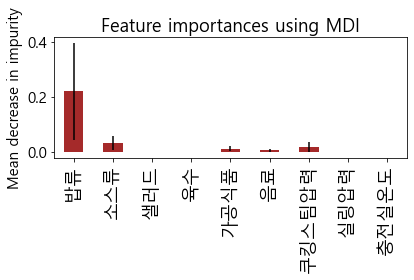

In [110]:
import pandas as pd

forest_importances = pd.Series(Importance[1:], index=Feature[1:])

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=18)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.rc('figure', titlesize=15) # figure title 폰트 크기

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[1:], ax=ax, color='brown')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [111]:
std

array([1.90874867e-01, 1.76163998e-01, 2.61217739e-02, 2.16163445e-04,
       9.05727876e-06, 1.02572483e-02, 6.88230241e-03, 1.78706266e-02,
       5.42856010e-04, 5.34095934e-04])

# cook_error_2
###  =>  충전실에서 온도/압력별 이상치에 대한 기계결함 True 의 수,,
- 쿠킹온도, 실링온도는 완전한 선형성  =>  

In [ ]:
# 충전실 데이터에서의 이상치 구하기  :  충전실온도, 실링온도, 쿠킹스팀압력, 실링압력

In [ ]:
# 1. 충전실온도 이상치 index 구하기
IQR_15 = (cook_error_2.충전실온도.quantile(.75) - cook_error_2.충전실온도.quantile(.25))*1.5
upper = cook_error_2.loc[cook_error_2.충전실온도 > cook_error_2.충전실온도.quantile(.75) + IQR_15].index.to_list()
lower = cook_error_2.loc[cook_error_2.충전실온도 < cook_error_2.충전실온도.quantile(.25) - IQR_15].index.to_list()
outlier_lst = upper + lower

# 충전실온도 이상치
print(cook_error_2.loc[outlier_lst].기계결함오류.value_counts())        # =>  기계결함오류 확률  = 7.56%

# 정상
print(cook_error_2.drop(index=outlier_lst).기계결함오류.value_counts()) #  =>  기계결함오류 확률  = 1.79%

                                                                        #  =>  전체 기계결함오류 확률    = 1.89%

In [ ]:
# 2. 실링온도 이상치 index 구하기
IQR_15 = (cook_error_2.실링온도.quantile(.75) - cook_error_2.실링온도.quantile(.25))*1.5
upper = cook_error_2.loc[cook_error_2.실링온도 > cook_error_2.실링온도.quantile(.75) + IQR_15].index.to_list()
lower = cook_error_2.loc[cook_error_2.실링온도 < cook_error_2.실링온도.quantile(.25) - IQR_15].index.to_list()
outlier_lst = upper + lower

# 충전실온도 이상치
print(cook_error_2.loc[outlier_lst].기계결함오류.value_counts())        # =>  기계결함오류 확률  = 0%

# 정상
print(cook_error_2.drop(index=outlier_lst).기계결함오류.value_counts()) #  =>  기계결함오류 확률  = 1.91%

                                                                        #  =>  전체 기계결함오류 확률    = 1.89%

In [ ]:
# 3. 쿠킹스팀압력 이상치 index 구하기
IQR_15 = (cook_error_2.쿠킹스팀압력.quantile(.75) - cook_error_2.쿠킹스팀압력.quantile(.25))*1.5
upper = cook_error_2.loc[cook_error_2.쿠킹스팀압력 > cook_error_2.쿠킹스팀압력.quantile(.75) + IQR_15].index.to_list()
lower = cook_error_2.loc[cook_error_2.쿠킹스팀압력 < cook_error_2.쿠킹스팀압력.quantile(.25) - IQR_15].index.to_list()
outlier_lst = upper + lower

# 충전실온도 이상치
print(cook_error_2.loc[outlier_lst].기계결함오류.value_counts())        # =>  기계결함오류 확률  = 36.68%

# 정상
print(cook_error_2.drop(index=outlier_lst).기계결함오류.value_counts()) #  =>  기계결함오류 확률  = 0.75%

                                                                        #  =>  전체 기계결함오류 확률    = 1.89%

In [49]:
# 4. 실링압력 이상치 index 구하기
IQR_15 = (cook_error_2.실링압력.quantile(.75) - cook_error_2.실링압력.quantile(.25))*1.5
upper = cook_error_2.loc[cook_error_2.실링압력 > cook_error_2.실링압력.quantile(.75) + IQR_15].index.to_list()
lower = cook_error_2.loc[cook_error_2.실링압력 < cook_error_2.실링압력.quantile(.25) - IQR_15].index.to_list()
outlier_lst = upper + lower

# 충전실온도 이상치
print(cook_error_2.loc[outlier_lst].기계결함오류.value_counts())        # =>  기계결함오류 확률  = 18.45%

# 정상
print(cook_error_2.drop(index=outlier_lst).기계결함오류.value_counts()) #  =>  기계결함오류 확률  = 1.73%

                                                                        #  =>  전체 기계결함오류 확률    = 1.89%

False    190
True      43
Name: 기계결함오류, dtype: int64
False    23423
True       413
Name: 기계결함오류, dtype: int64


In [50]:
# 5. 쿠킹온도 이상치 index 구하기
IQR_15 = (cook_error_2.쿠킹온도.quantile(.75) - cook_error_2.쿠킹온도.quantile(.25))*1.5
upper = cook_error_2.loc[cook_error_2.쿠킹온도 > cook_error_2.쿠킹온도.quantile(.75) + IQR_15].index.to_list()
lower = cook_error_2.loc[cook_error_2.쿠킹온도 < cook_error_2.쿠킹온도.quantile(.25) - IQR_15].index.to_list()
outlier_lst = upper + lower

# 충전실온도 이상치
print(cook_error_2.loc[outlier_lst].기계결함오류.value_counts())        # =>  기계결함오류 확률  = 0%

# 정상
print(cook_error_2.drop(index=outlier_lst).기계결함오류.value_counts()) #  =>  기계결함오류 확률  = 1.91%

                                                                        #  =>  전체 기계결함오류 확률    = 1.89%

False    318
Name: 기계결함오류, dtype: int64
False    23295
True       456
Name: 기계결함오류, dtype: int64
